# Imports

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import pyLDAvis.sklearn
from pylab import bone, pcolor, colorbar, plot, show, rcParams, savefig
from itertools import chain
import pickle
import spacy
from collections import Iterable
import ast

from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AffinityPropagation, KMeans, DBSCAN, Birch, MiniBatchKMeans, OPTICS
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/tmp/ipykernel_3033/26246093.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


# Import Dataset and Build Tokenset

This section uses the nlp.pipe method to build out the document set and then passes the tokenset to a seperate function that lemmatizses the words, removes stopwords, and removes punctation.

In [2]:
def lemmatizer_alt(input):
    lemma_list = [token.lemma_ for token in input if token.is_stop == False and token.is_punct==False]

    return lemma_list

def build_dataset():
    wiki = pd.read_csv('assets/WikiLarge_Train.csv')

    l_start = time.time()
    nlp = spacy.load("en_core_web_sm", exclude=['parser', "ner"])
    wiki['nlp_text'] =  [doc for doc in nlp.pipe(wiki["original_text"].tolist())]
    wiki['tokenized_text'] = wiki["nlp_text"].apply(lemmatizer_alt)
    l_duration = time.time() - l_start
    print('Pipe Model Timing: {:.2f} seconds'.format(l_duration), flush=True)

    wiki = wiki[[
        'original_text',
        'label',
        'tokenized_text'
    ]]

    wiki.to_csv('outputs/wiki_tokenized.csv')
    
    return 0

In [3]:
build_dataset()

Pipe Model Timing: 313.40 seconds


# Build LDA

The LDA build proceeds through the following steps:
1. Vectorization of the tokenset built in the previous step.
2. Setup of GridSearch parameters.
3. Search of the LDA model through the parameters.
4. Pickling of the final best model, vectorizer, grid search results, and others.

The GridSearch will default to log-likelihood, which should be sufficent here.

In [165]:
def lda_build():

    l_start = time.time()
    wiki = pd.read_csv('outputs/wiki_tokenized.csv')
    wiki['token_list'] = wiki['tokenized_text'].apply(ast.literal_eval)
    input_list = wiki['token_list'].str.join(" ")
    l_duration = time.time() - l_start
    print('List Construction: {:.2f} seconds'.format(l_duration), flush=True)
    
    l_start = time.time()
    vectorizer = TfidfVectorizer(
        analyzer='word',       
        min_df=10,
        token_pattern='[a-zA-Z0-9]{4,}' # Ensure every token is at least 4 char long
    )
    data_vectorized = vectorizer.fit_transform(input_list)
    l_duration = time.time() - l_start
    print("Number of topics: {:.0f}".format(data_vectorized.shape[1]))
    print('Vector Construction: {:.2f} seconds'.format(l_duration), flush=True)
    
    search_params = {
        'n_components': [10, 15, 20], 
        'learning_decay': [.5, .7, .9]
    }

    l_start = time.time()
    lda = LatentDirichletAllocation(
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=42,
        verbose=1
    )
    
    model = GridSearchCV(
        lda, 
        param_grid=search_params,
        verbose=1,
        n_jobs=1
    )
    
    model.fit(data_vectorized)
    l_duration = time.time() - l_start
    print('LDA Grid Search: {:.2f} seconds'.format(l_duration), flush=True)
    
    l_start = time.time()
    best_lda_model = model.best_estimator_
    data_lda = best_lda_model.transform(data_vectorized)
    search_results = model.cv_results_
    l_duration = time.time() - l_start
    print('Grid Search Data Extraction: {:.2f} seconds'.format(l_duration), flush=True)

    pickle.dump(vectorizer, open("outputs/vectorizer.pkl", "wb"))
    pickle.dump(data_vectorized, open("outputs/data_vectorized.pkl", "wb"))
    pickle.dump(data_lda, open("outputs/data_lda.pkl", "wb"))
    pickle.dump(best_lda_model, open("outputs/lda_model.pkl", 'wb'))
    pickle.dump(search_results, open("outputs/grid_search_results.pkl", 'wb'))

    return 0

In [166]:
lda_build()

List Construction: 12.25 seconds
Number of topics: 26079
Vector Construction: 3.96 seconds
Fitting 5 folds for each of 9 candidates, totalling 45 fits
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
iteration

0

# Grid Search Review
This section plots the log-likelyhood across models from grid_search_results.pkl

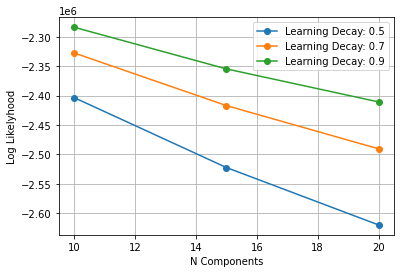

In [56]:
grid_data = pickle.load(open("outputs/grid_search_results.pkl", "rb"))
search_params = {
    'n_components': [10, 15, 20], 
    'learning_decay': [.5, .7, .9]
}
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    _, ax = plt.subplots(1,1)

    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_xlabel(name_param_1)
    ax.set_ylabel('Log Likelyhood')
    ax.legend(loc="best")
    ax.grid('on')

plot_grid_search(grid_data, search_params['n_components'], search_params['learning_decay'], 'N Components', 'Learning Decay')

# LDA Plotting
This section creates an interactive plot of the LDA model for examination of the topics extracted from the document.

In [167]:
def LDA_plot():
    lda_model = pickle.load(open("outputs/lda_model.pkl", "rb"))
    data_vectorized = pickle.load(open("outputs/data_vectorized.pkl", "rb"))
    vectorizer = pickle.load(open("outputs/vectorizer.pkl", "rb"))
    pyLDAvis.enable_notebook()
    dash = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
    return dash

In [168]:
LDA_plot()

/home/tgeasley/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/home/tgeasley/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
8      32.420952   8.115230       1        1  14.897011
3       0.648955  71.707100       2        1  11.627410
1      71.019684   9.971006       3        1  11.387701
5       3.785981  33.185135       4        1  10.681627
7     -42.666500  -9.222070       5        1  10.188302
2      -3.621689 -43.526516       6        1  10.027134
6      -3.632402  -4.171708       7        1   9.378977
9     -36.584400  35.804413       8        1   8.131606
0      44.391380  50.615383       9        1   7.370220
4      40.235809 -31.591665      10        1   6.310012, topic_info=             Term         Freq        Total Category  logprob  loglift
5596      commune  4789.000000  4789.000000  Default  30.0000  30.0000
9492       france  4935.000000  4935.000000  Default  29.0000  29.0000
6933   department  4401.000000  4401.000000  Default  28.0000  28.0000
19734      region  3759.000000  3759.000000  Default  27.0000  27.0000
4223       calais  2186.000000  2186.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
25476     western   461.811424  1154.978309  Topic10  -5.0069   1.8464
14054        link   333.740217   583.601969  Topic10  -5.3317   2.2042
25882        year   406.905321  2589.741519  Topic10  -5.1335   0.9123
25473        west   347.124092  1481.180091  Topic10  -5.2924   1.3121
6172       county   298.171981  1975.100608  Topic10  -5.4444   0.8723

[689 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
664       10  0.997268       1913
673        1  0.987640       1921
679        6  0.992785       1927
684        2  0.992597       1931
697        2  0.995835       1943
...      ...       ...        ...
25882      7  0.045564       year
25882      8  0.016604       year
25882      9  0.031663       year
25882     10  0.157159       year
25926      3  0.990389  yorkshire

[1780 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 2, 6, 8, 3, 7, 10, 1, 5])

# Tag Application

Next the LDA model is used to generate the top n tags for each article.  Will only function for articles with at least n tags because otherwise vectorization and clustering won't work as vectors will have different sizes

In [135]:
def tag_df(n_items):
    wiki = pd.read_csv('outputs/wiki_tokenized.csv')
    lda_model = pickle.load(open("outputs/lda_model.pkl", "rb"))
    data_vectorized = pickle.load(open("outputs/data_vectorized.pkl", "rb"))
    vectorizer = pickle.load(open("outputs/vectorizer.pkl", "rb"))
    
    threshold = 0 #Arbitrary, might change
    n_topics = 10  # Change to best fit
    

    list_scores = []
    list_words = []

    feature_names = np.array(vectorizer.get_feature_names())
    lda_components = lda_model.components_ #/ lda_model.components_.sum(axis=1)[:, np.newaxis] # normalization

    total_length = len(wiki)
    return_df = {
        'index': [],
        'tag': []
    }
    
    for index, row in wiki.iterrows():

        if index % 1000 == 0 and index > 0:
            print('Percent complete: {:.2%}'.format(index/total_length))

        text_projection = data_vectorized[index,:].toarray()
        
        element_score = np.multiply(text_projection[0],lda_components)
        non_zero = np.nonzero(element_score)
        
        l_words = {}
        for i,j in zip(non_zero[0],non_zero[1]):
            if feature_names[j] in l_words:
                l_words[feature_names[j] ] += element_score[i,j]
            else:
                l_words[feature_names[j] ] = element_score[i,j]
        l_words = [k for k, v in sorted(l_words.items(), key=lambda item: item[1], reverse=True)]
        if len(l_words) >= n_items:
            l_words = l_words[:n_items]
            
        
        return_df['index'].append(index)
        return_df['tag'].append(" ".join(list(l_words)))
        
    return_df = pd.DataFrame(return_df).set_index('index')
    wiki = wiki.join(return_df)
    return wiki

In [136]:
tagged_df = tag_df(5)
tagged_df.to_csv('outputs/tagged_df.csv')
tagged_df.head(5)

Percent complete: 0.24%
Percent complete: 0.48%
Percent complete: 0.72%
Percent complete: 0.96%
Percent complete: 1.20%
Percent complete: 1.44%
Percent complete: 1.68%
Percent complete: 1.92%
Percent complete: 2.16%
Percent complete: 2.40%
Percent complete: 2.64%
Percent complete: 2.88%
Percent complete: 3.12%
Percent complete: 3.36%
Percent complete: 3.60%
Percent complete: 3.84%
Percent complete: 4.08%
Percent complete: 4.32%
Percent complete: 4.56%
Percent complete: 4.80%
Percent complete: 5.04%
Percent complete: 5.28%
Percent complete: 5.52%
Percent complete: 5.76%
Percent complete: 6.00%
Percent complete: 6.24%
Percent complete: 6.48%
Percent complete: 6.72%
Percent complete: 6.96%
Percent complete: 7.20%
Percent complete: 7.44%
Percent complete: 7.68%
Percent complete: 7.92%
Percent complete: 8.16%
Percent complete: 8.40%
Percent complete: 8.64%
Percent complete: 8.88%
Percent complete: 9.12%
Percent complete: 9.36%
Percent complete: 9.60%
Percent complete: 9.84%
Percent complete

Percent complete: 79.42%
Percent complete: 79.66%
Percent complete: 79.90%
Percent complete: 80.14%
Percent complete: 80.38%
Percent complete: 80.62%
Percent complete: 80.86%
Percent complete: 81.10%
Percent complete: 81.34%
Percent complete: 81.58%
Percent complete: 81.82%
Percent complete: 82.06%
Percent complete: 82.30%
Percent complete: 82.54%
Percent complete: 82.78%
Percent complete: 83.02%
Percent complete: 83.26%
Percent complete: 83.50%
Percent complete: 83.74%
Percent complete: 83.98%
Percent complete: 84.22%
Percent complete: 84.46%
Percent complete: 84.70%
Percent complete: 84.94%
Percent complete: 85.18%
Percent complete: 85.42%
Percent complete: 85.66%
Percent complete: 85.90%
Percent complete: 86.14%
Percent complete: 86.38%
Percent complete: 86.62%
Percent complete: 86.86%
Percent complete: 87.10%
Percent complete: 87.34%
Percent complete: 87.58%
Percent complete: 87.82%
Percent complete: 88.06%
Percent complete: 88.30%
Percent complete: 88.54%
Percent complete: 88.78%


,Unnamed: 0,original_text,label,tokenized_text,tags,value
0,0,There is manuscript evidence that Austen conti...,1,"['manuscript', 'evidence', 'Austen', 'continue...",0,work late period james continue
1,1,"In a remarkable comparative analysis , Mandaea...",1,"['remarkable', 'comparative', 'analysis', 'man...",0,text thomas relate scholar closely
2,2,"Before Persephone was released to Hermes , who...",1,"['Persephone', 'release', 'Hermes', 'send', 'r...",0,year release force period return
3,3,Cogeneration plants are commonly found in dist...,1,"['cogeneration', 'plant', 'commonly', 'find', ...",0,city find plant district large
4,4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,"['Geneva', '-LRB-', '-rrb-', 'second', 'populo...",0,city switzerland second french speak


# Tag Grouping

This next section applies a number of clustering methods to the tags generated in the previous section.  In order to reduce the search space the tags are vectorized and then transformed according to the LDA number of topics.

In [2]:
tagged_df = pd.read_csv('outputs/tagged_df.csv')
tagged_df.head(5)

,Unnamed: 0,original_text,label,tokenized_text,tags,cluster
0,0,There is manuscript evidence that Austen conti...,1,"['manuscript', 'evidence', 'Austen', 'continue...",work late period james continue,169
1,1,"In a remarkable comparative analysis , Mandaea...",1,"['remarkable', 'comparative', 'analysis', 'man...",text thomas relate scholar closely,402
2,2,"Before Persephone was released to Hermes , who...",1,"['Persephone', 'release', 'Hermes', 'send', 'r...",year release force period return,37
3,3,Cogeneration plants are commonly found in dist...,1,"['cogeneration', 'plant', 'commonly', 'find', ...",city find plant district large,901
4,4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1,"['Geneva', '-LRB-', '-rrb-', 'second', 'populo...",city switzerland second french speak,300


In [35]:
def other_tags(input_df, tag_label, return_scores = None):
    
    method = []
    method_scores = []

    l_start = time.time()
    lda_model = pickle.load(open("outputs/lda_model.pkl", "rb"))
    vectorizer = pickle.load(open("outputs/vectorizer.pkl", "rb"))
    input_df = input_df[input_df[tag_label].str.len()>0]
    X_i = vectorizer.transform(input_df[tag_label])
    print(X_i.shape)
    print(lda_model.components_.shape)
    X = X_i @ lda_model.components_.T
    print(X.shape)
    l_duration = time.time() - l_start
    print('Vectorization: {:.2f} seconds'.format(l_duration), flush=True)
    
    
    l_start = time.time()
    lda_cluster = np.argmax(X, axis=1)
    l_duration = time.time() - l_start
    print('LDA clustering: {:.2f} seconds'.format(l_duration), flush=True)
    print(lda_cluster.shape)
    lda_ss = silhouette_score(X, lda_cluster, sample_size=10000)  #Depending on speed, may need to change sample size
    print('Lda score: {:.4f}'.format(lda_ss), flush=True)
    method.append('LDA')
    method_scores.append(lda_ss)
    
    #DBSCAN
    l_start = time.time()
    db_clustering = DBSCAN(eps=3, min_samples=2).fit(X)
    l_duration = time.time() - l_start
    print('DBSCAN: {:.2f} seconds'.format(l_duration), flush=True)
    
    num_clusters = len(list(set(db_clustering.labels_)))
    db_ss = silhouette_score(X, db_clustering.labels_, sample_size=10000)  #Depending on speed, may need to change sample size
    
    
    print('DBSCAN score: {:.4f}'.format(db_ss), flush=True)
    print("DBSCAN number of clusters: " +str(num_clusters))
    method.append('DBSCAN')
    method_scores.append(db_ss)
    
    index_range = np.arange(0,X.shape[0],1000)
    
    #BIRCH
    l_start = time.time()
    brc = Birch(n_clusters=None)
    for index,val in enumerate(index_range):
        #print('Birch Current index: '+str(index))
        #l_start = time.time()
        if index+1 >= len(index_range):
            brc = brc.partial_fit(X[val:X.shape[0],:])
        else:
            brc = brc.partial_fit(X[val:index_range[index+1],:])
        #l_duration = time.time() - l_start
    
    l_duration = time.time() - l_start
    print('BIRCH fit: {:.2f} seconds'.format(l_duration), flush=True)

    l_start = time.time()
    brc_labels = brc.predict(X)
    num_clusters = len(list(set(brc_labels)))
    l_duration = time.time() - l_start
    print('BIRCH predict: {:.2f} seconds'.format(l_duration), flush=True)
    print("Birch number of clusters: " +str(num_clusters))
    
    birch_ss = silhouette_score(X, brc_labels, sample_size=10000)  #Depending on speed, may need to change sample size
    print('Birch score: {:.4f}'.format(birch_ss), flush=True)
    
    method.append('BIRCH')
    method_scores.append(birch_ss)
    
    if return_scores is None:
        return_scores = pd.DataFrame({
            'method':method,
            'method_scores':method_scores,
        })
    else:
        l_return_scores = pd.DataFrame({
            'method':method,
            'method_scores':method_scores,
        })
        return_scores.append(l_return_scores, ignore_index=True)
        
    
    
    return return_scores

def k_means_tags(input_df, tag_label, return_scores = None):
    
    method = []
    method_scores = []

    interial_clusters = []
    intertia = []
    
    l_start = time.time()
    lda_model = pickle.load(open("outputs/lda_model.pkl", "rb"))
    vectorizer = pickle.load(open("outputs/vectorizer.pkl", "rb"))
    input_df = input_df[input_df[tag_label].str.len()>0]
    X_i = vectorizer.transform(input_df[tag_label])
    print(X_i.shape)
    print(lda_model.components_.shape)
    X = X_i @ lda_model.components_.T
    print(X.shape)
    l_duration = time.time() - l_start
    print('Vectorization: {:.2f} seconds'.format(l_duration), flush=True)
    
    index_range = np.arange(0,X.shape[0],1000)
    cluster_range = [10,30,50,70,100,300,400,500,600,700,800,900,1000]
    
    for el in cluster_range:
        kmeans = MiniBatchKMeans(n_clusters=el,random_state=0,batch_size=6)
        l_start = time.time()
        for index,val in enumerate(index_range):
            if index+1 >= len(index_range):
                kmeans = kmeans.partial_fit(X[val:X.shape[0],:])
            else:
                kmeans = kmeans.partial_fit(X[val:index_range[index+1],:])
        l_duration = time.time() - l_start
        print('Kmeans fit: {:.2f} seconds'.format(l_duration), flush=True)


        l_start = time.time()
        kmeans_labels = kmeans.predict(X)
        l_duration = time.time() - l_start
        print('Kmeans predict: {:.2f} seconds'.format(l_duration), flush=True)

        kmeans_ss = silhouette_score(X, kmeans_labels, sample_size=10000)  #Depending on speed, may need to change sample size
        print('Kmeans score: {:.4f}'.format(kmeans_ss), flush=True)
        print("Number of clusters: " +str(el))
        
        method.append('K Means '+str(el)+' clusters')
        method_scores.append(kmeans_ss)
        
        interial_clusters.append(el)
        intertia.append(kmeans.inertia_)
        

    inertia_scores = pd.DataFrame({
        'interia_clusters': interial_clusters,
        'interia_score': intertia
    })
    if return_scores is None:
        return_scores = pd.DataFrame({
            'method':method,
            'method_scores':method_scores,
        })
    else:
        l_return_scores = pd.DataFrame({
            'method':method,
            'method_scores':method_scores,
        })
        return_scores = return_scores.append(l_return_scores, ignore_index=True)
    
    return pd.DataFrame(inertia_scores),return_scores

In [36]:
oth_scores = other_tags(tagged_df, 'tags')

(412305, 26079)
(10, 26079)
(412305, 10)
Vectorization: 2.21 seconds
LDA clustering: 0.01 seconds
(412305,)
Lda score: -0.0565
DBSCAN: 11.41 seconds
DBSCAN score: -0.3433
DBSCAN number of clusters: 65135
BIRCH fit: 714.97 seconds
BIRCH predict: 1186.76 seconds
Birch number of clusters: 279271
Birch score: 0.0870


In [37]:
inertia_dict, score_dict = k_means_tags(tagged_df, 'tags', oth_scores)

(412305, 26079)
(10, 26079)
(412305, 10)
Vectorization: 2.34 seconds
Kmeans fit: 0.55 seconds
Kmeans predict: 7.96 seconds
Kmeans score: 0.2398
Number of clusters: 10
Kmeans fit: 0.92 seconds
Kmeans predict: 10.19 seconds
Kmeans score: 0.2234
Number of clusters: 30
Kmeans fit: 1.25 seconds
Kmeans predict: 9.42 seconds
Kmeans score: 0.1823
Number of clusters: 50
Kmeans fit: 1.52 seconds
Kmeans predict: 9.67 seconds
Kmeans score: 0.1779
Number of clusters: 70
Kmeans fit: 1.98 seconds
Kmeans predict: 9.74 seconds
Kmeans score: 0.1545
Number of clusters: 100
Kmeans fit: 4.94 seconds
Kmeans predict: 10.09 seconds
Kmeans score: 0.1374
Number of clusters: 300
Kmeans fit: 6.12 seconds
Kmeans predict: 12.31 seconds
Kmeans score: 0.1434
Number of clusters: 400
Kmeans fit: 7.42 seconds
Kmeans predict: 11.83 seconds
Kmeans score: 0.1432
Number of clusters: 500
Kmeans fit: 8.27 seconds
Kmeans predict: 11.16 seconds
Kmeans score: 0.1344
Number of clusters: 600
Kmeans fit: 9.30 seconds
Kmeans predict

In [38]:
score_dict.head()

,method,method_scores
0,LDA,-0.056452
1,DBSCAN,-0.343295
2,BIRCH,0.087045
3,K Means 10 clusters,0.239751
4,K Means 30 clusters,0.223354


# Clustering Evaluation
The next section evaluates the results of the clustering methods applied previously and then selects the best model for use in the final section of building a word cloud.

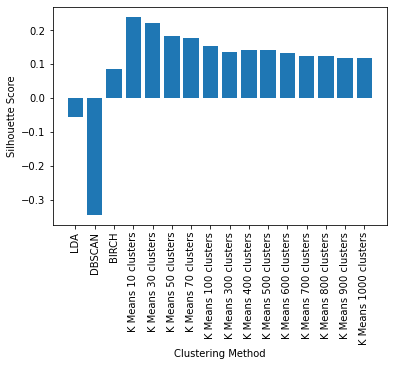

In [42]:
method = score_dict['method'].to_list()
method_scores = score_dict['method_scores'].to_list()

plt.bar(method, method_scores)
plt.xlabel("Clustering Method")
plt.xticks(rotation=90)
plt.ylabel("Silhouette Score")
plt.show()

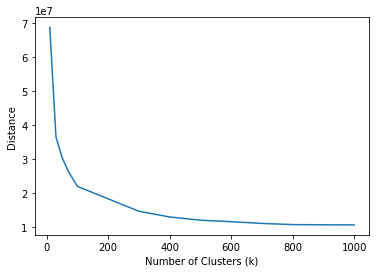

In [14]:
#Plot kmeans inertia
range_n_clusters = inertia_dict['interia_clusters'].to_list()
avg_distance = inertia_dict['interia_score'].to_list()

plt.plot(range_n_clusters, avg_distance)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distance")
plt.show()

In [16]:
def tag_best_k_means(input_df, tag_label, num_clusters):
    
    l_start = time.time()
    lda_model = pickle.load(open("outputs/lda_model.pkl", "rb"))
    vectorizer = pickle.load(open("outputs/vectorizer.pkl", "rb"))
    input_df = input_df[input_df[tag_label].str.len()>0]
    X_i = vectorizer.transform(input_df[tag_label])
    print(X_i.shape)
    print(lda_model.components_.shape)
    X = X_i @ lda_model.components_.T
    print(X.shape)
    l_duration = time.time() - l_start
    print('Vectorization: {:.2f} seconds'.format(l_duration), flush=True)
    
    index_range = np.arange(0,X.shape[0],1000)

    kmeans = MiniBatchKMeans(n_clusters=num_clusters,random_state=0,batch_size=6)
    l_start = time.time()
    for index,val in enumerate(index_range):
        if index+1 >= len(index_range):
            kmeans = kmeans.partial_fit(X[val:X.shape[0],:])
        else:
            kmeans = kmeans.partial_fit(X[val:index_range[index+1],:])
    l_duration = time.time() - l_start
    print('Kmeans fit: {:.2f} seconds'.format(l_duration), flush=True)


    l_start = time.time()
    kmeans_labels = kmeans.predict(X)
    l_duration = time.time() - l_start
    print('Kmeans predict: {:.2f} seconds'.format(l_duration), flush=True)
    
    input_df['cluster'] = kmeans_labels

    
    
    return input_df

In [17]:
tag_df = tag_best_k_means(tagged_df, 'tags', 400)

(412305, 26079)
(10, 26079)
(412305, 10)
Vectorization: 2.43 seconds
Kmeans fit: 6.13 seconds
Kmeans predict: 10.59 seconds


# Word Clouds
This next section generates word clouds for a particular cluster.

In [45]:
def gen_word_cloud(df, tag_col, cluster, cluster_col):
    # Read the whole text.
    text = df[df[cluster_col]==cluster][tag_col].str.cat(sep=' ')

    # Generate a word cloud image
    wordcloud = WordCloud().generate(text)

    # Display the generated image:
    # the matplotlib way:
    
    #plt.imshow(wordcloud, interpolation='bilinear')
    #plt.axis("off")

    # lower max_font_size
    wordcloud = WordCloud(background_color="white", repeat=True).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    #plt.show()
    
    return plt

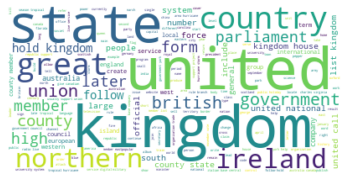

In [46]:
gen_word_cloud(tag_df, 'tags',3,'cluster').show()

In [58]:
tag_df.to_csv('outputs/tagged_df.csv')